# Automatic Feature Engineering with Featuretools
by Matthew Emery

In [42]:
import pandas as pd
from xgboost import XGBClassifier, plot_importance
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
import featuretools as ft
from random import sample
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer, StandardScaler
from mlxtend.classifier import StackingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from hpsklearn import HyperoptEstimator, any_classifier, xgboost_classification, sgd

In [52]:
train_df = pd.read_csv("data/train.csv")
train_target = train_df["Survived"]
train_features = train_df.drop(columns="Survived")
train_features['Pclass'] = train_features['Pclass'].astype('category')
train_features.sample(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
191,192,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.000,NaN,S
433,434,3,"Kallio, Mr. Nikolai Erland",male,17.0,0,0,STON/O 2. 3101274,7.125,NaN,S
344,345,2,"Fox, Mr. Stanley Hubert",male,36.0,0,0,229236,13.000,NaN,S
392,393,3,"Gustafsson, Mr. Johan Birger",male,28.0,2,0,3101277,7.925,NaN,S
553,554,3,"Leeni, Mr. Fahim (""Philip Zenni"")",male,22.0,0,0,2620,7.225,NaN,C


In [81]:
basic_features = pd.get_dummies(train_features.drop(columns=["Name", "PassengerId", "Ticket", "Cabin"]))

dummy_model = DummyClassifier(random_state=0)
dummy_cv = cross_val_score(dummy_model, basic_features, train_target, cv=10)
dummy_cv.mean(), dummy_cv.std()

ValueError: labels ['Name' 'Ticket' 'Cabin'] not contained in axis

In [66]:
basic_model = XGBClassifier(random_state=0)
basic_cv = cross_val_score(basic_model, basic_features, train_target, cv=10)
basic_cv.mean(), basic_cv.std()

(0.8261133810010215, 0.0318043494707937)

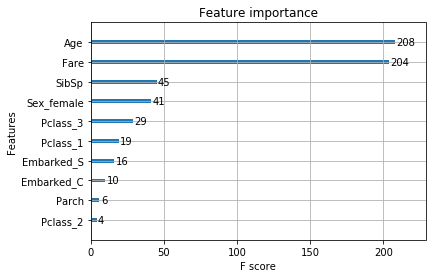

In [79]:
basic_model.fit(basic_features, train_target)
plot_importance(basic_model, max_num_features=20)

In [80]:
#How about some feature engineering?
ft_features = train_features.drop(columns=["Name", "Ticket", "Cabin"])
es = ft.EntitySet(id="titanic")
es.entity_from_dataframe(entity_id="titanic",
                         dataframe=ft_features,
                         index="PassengerId",
                         variable_types={
                             "Pclass": ft.variable_types.Categorical,
                             "Sex": ft.variable_types.Categorical,
                             "Embarked": ft.variable_types.Categorical
                           })
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="classes",
                index="Pclass")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="sexes",
                index="Sex")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="embarkeds",
                index="Embarked")

ValueError: labels ['Name' 'Ticket' 'Cabin'] not contained in axis

In [29]:
feature_matrix, features = ft.dfs(entityset=es,
                              target_entity="titanic",
                              save_progress="results/",
                              verbose=True)

feature_matrix, features = ft.encode_features(feature_matrix, features)

feature_matrix.sample(5)

Built 94 features
Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|██████████|| Calculated: 1/1 cutoff times


,Age,SibSp,Parch,Fare,Pclass = 3,Pclass = 1,Pclass = 2,Pclass = unknown,Sex = male,Sex = female,...,embarkeds.MEAN(titanic.Parch),embarkeds.MEAN(titanic.Fare),embarkeds.COUNT(titanic),embarkeds.NUM_UNIQUE(titanic.Pclass),embarkeds.NUM_UNIQUE(titanic.Sex),embarkeds.MODE(titanic.Pclass) = 3.0,embarkeds.MODE(titanic.Pclass) = 1.0,embarkeds.MODE(titanic.Pclass) = unknown,embarkeds.MODE(titanic.Sex) = male,embarkeds.MODE(titanic.Sex) = unknown
PassengerId,,,,,,,,,,,,,,,,,,,,,
268,25.0,1,0,7.7750,1,0,0,0,1,0,...,0.413043,27.079812,644.0,3.0,2.0,1,0,0,1,0
862,21.0,1,0,11.5000,0,0,1,0,1,0,...,0.413043,27.079812,644.0,3.0,2.0,1,0,0,1,0
172,4.0,4,1,29.1250,1,0,0,0,1,0,...,0.168831,13.276030,77.0,3.0,2.0,1,0,0,1,0
680,36.0,0,1,512.3292,0,1,0,0,1,0,...,0.363095,59.954144,168.0,3.0,2.0,0,1,0,1,0
389,NaN,0,0,7.7292,1,0,0,0,1,0,...,0.168831,13.276030,77.0,3.0,2.0,1,0,0,1,0


In [30]:
sample(features, 5)

[<Feature: classes.STD(titanic.Age)>,
 <Feature: embarkeds.SKEW(titanic.Fare)>,
 <Feature: Fare>,
 <Feature: sexes.COUNT(titanic)>,
 <Feature: classes.SKEW(titanic.Fare)>]

In [31]:
ft_cv = cross_val_score(basic_model, feature_matrix, train_target, cv=10)
ft_cv.mean(), ft_cv.std()

(0.823891442515038, 0.03353671785874994)

In [53]:
train_features['CabinClass'] = train_features["Cabin"].str.get(0)
train_features['LastName'] = train_features['Name'].str.split(", ").apply(lambda x: x[0])
train_features['Honorific'] = train_features['Name'].str.extract(" ([a-zA-z]+)")
train_features['TicketPrefix'] = train_features['Ticket'].str.extract("(.+) ")
# train_features['TicketNumber'] = train_features['Ticket'].str.extract("([0-9]+)$").astype(float)
train_features = train_features.drop(columns=["Name", "Cabin", "Ticket"])

In [60]:
es = ft.EntitySet(id="titanic")
es.entity_from_dataframe(entity_id="titanic",
                         dataframe=train_features,
                         index="PassengerId",
                         variable_types={
                             "Pclass": ft.variable_types.Categorical,
                             "Sex": ft.variable_types.Categorical,
                             "Embarked": ft.variable_types.Categorical,
                             "CabinClass": ft.variable_types.Categorical,
                             "LastName": ft.variable_types.Categorical,
                             "Honorific": ft.variable_types.Categorical,
                             "TicketPrefix": ft.variable_types.Categorical
                           })
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="classes",
                index="Pclass")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="sexes",
                index="Sex")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="embarkeds",
                index="Embarked")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="cabinclasses",
                index="CabinClass")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="honorfics",
                index="Honorific")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="lastnames",
                index="LastName")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="ticketprefixes",
                index="TicketPrefix")

feature_matrix, features = ft.dfs(entityset=es,
                              target_entity="titanic",
                              save_progress="results/",
                              verbose=True)

feature_matrix, features = ft.encode_features(feature_matrix, features)

feature_matrix.sample(5)

Built 270 features
Elapsed: 00:03 | Remaining: 00:00 | Progress: 100%|██████████|| Calculated: 1/1 cutoff times


,Age,SibSp,Parch,Fare,Pclass = 3,Pclass = 1,Pclass = 2,Pclass = unknown,Sex = male,Sex = female,...,ticketprefixes.MODE(titanic.LastName) = Corn,ticketprefixes.MODE(titanic.LastName) = Hakkarainen,ticketprefixes.MODE(titanic.LastName) = unknown,ticketprefixes.MODE(titanic.Honorific) = Mr,ticketprefixes.MODE(titanic.Honorific) = Miss,ticketprefixes.MODE(titanic.Honorific) = Master,ticketprefixes.MODE(titanic.Honorific) = Capt,ticketprefixes.MODE(titanic.Honorific) = Rev,ticketprefixes.MODE(titanic.Honorific) = Mrs,ticketprefixes.MODE(titanic.Honorific) = unknown
PassengerId,,,,,,,,,,,,,,,,,,,,,
729,25.0,1,0,26.000,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,1
46,NaN,0,0,8.050,1,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0
118,29.0,1,0,21.000,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,1
465,NaN,0,0,8.050,1,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0
240,33.0,0,0,12.275,0,0,1,0,1,0,...,0,0,1,1,0,0,0,0,0,0


In [68]:
expanded_ft_cv = cross_val_score(basic_model, feature_matrix, train_target, cv=10)
expanded_ft_cv.mean(), expanded_ft_cv.std()

(0.8372869140846669, 0.041087687111902735)

In [75]:
pipeline = make_pipeline(
    Imputer(strategy='median'),
    SelectFromModel(ExtraTreesClassifier(random_state=0, n_estimators=100), 'median'),
    XGBClassifier(random_state=0)
)

selected_ft_cv = cross_val_score(pipeline, feature_matrix, train_target, cv=10)
selected_ft_cv.mean(), selected_ft_cv.std()

(0.8394966519123823, 0.0395795692850875)

In [84]:
import seaborn as sns
import numpy as np
%matplotlib inline

In [76]:
basic_cv, ft_cv, expanded_ft_cv, selected_ft_cv

(array([0.8       , 0.8       , 0.7752809 , 0.87640449, 0.85393258,
        0.83146067, 0.85393258, 0.78651685, 0.84269663, 0.84090909]),
 array([0.78888889, 0.8       , 0.7752809 , 0.87640449, 0.86516854,
        0.83146067, 0.82022472, 0.78651685, 0.84269663, 0.85227273]),
 array([0.83333333, 0.82222222, 0.74157303, 0.88764045, 0.87640449,
        0.79775281, 0.84269663, 0.85393258, 0.87640449, 0.84090909]),
 array([0.82222222, 0.86666667, 0.76404494, 0.88764045, 0.8988764 ,
        0.78651685, 0.83146067, 0.84269663, 0.85393258, 0.84090909]))

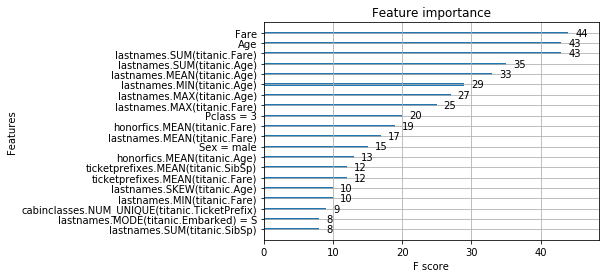

In [77]:
basic_model.fit(feature_matrix, train_target)
plot_importance(basic_model, max_num_features=20)

In [100]:
from itertools import chain
df = pd.DataFrame(
    {"Model": list(chain.from_iterable([[x] * 10 for x in ("Basic Features", 
                                                           "Naive Featuretools",
                                                           "Smarter Featuretools",
                                                           "Selected Featuretools")])),
        "CV Fold Accuracy": np.concatenate([basic_cv, ft_cv, expanded_ft_cv, selected_ft_cv])} )

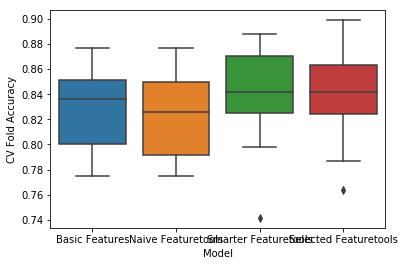

In [114]:
sns.boxplot("Model", "CV Fold Accuracy", data = df)

In [ ]:
tr